<a href="https://colab.research.google.com/github/pallavi-2000/pallavi2000/blob/main/Code_For_Dust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import numpy as np
import astropy.units as u
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from astropy.utils.data import get_pkg_data_filename
import astropy.visualization as vis
from astropy.io import ascii
import math
import pylab as p
from matplotlib import *
from scipy import *
from matplotlib.ticker import FormatStrFormatter

In [3]:
import pandas as pd

In [4]:
datapath='G350_tdenscube.fits'
headpath='G350_sigtdenscube.fits'
xray_hdu = fits.open('G350.1-0.3_XrayChandra1.fits')[0]

In [5]:
# defining variables and setting up temp array
betas=np.array([2.0])
n_arrays = len(betas)
print('no of beta values we are looping over',n_arrays)

no of beta values we are looping over 1


In [6]:
# temperature information
tempno=12
# need to change next two lines if temp range different
lowertemp=15.
highertemp=70.
temp = np.logspace(np.log10(lowertemp),np.log10(highertemp),tempno) # separates into the 12 bins
float_temp = ["{:.1f}".format(float(elem)) for elem in temp] # make temp a float for latex table purposes


In [7]:
#set up SNR details
# locations
g350_ra = 260.5250 #260.2750 # in degrees
g350_ap = 260.28
g350_dec = -37.4483 # in degrees
g350_dust_size = 55./(60*60) # in degrees

contours = None


In [8]:
#loading in data
dataA = fits.getdata(datapath)[0]

bigdata = np.array([dataA]) # set up like this in case of more betas

In [9]:
pip install photutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.6 MB/s eta 0:00:00


In [10]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from photutils.aperture import SkyCircularAnnulus
from astropy import stats

In [11]:
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
from photutils import CircularAnnulus, CircularAperture

<ipython-input-11-c4b6bf66f3b5>:1: DeprecationWarning: `photutils.SkyCircularAperture` is a deprecated alias for `photutils.aperture.SkyCircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import SkyCircularAperture` to silence this warning.
  from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
<ipython-input-11-c4b6bf66f3b5>:1: DeprecationWarning: `photutils.SkyCircularAnnulus` is a deprecated alias for `photutils.aperture.SkyCircularAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import SkyCircularAnnulus` to silence this warning.
  from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
<ipython-input-11-c4b6bf66f3b5>:1: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometr

In [12]:
# get the aperture details
positions=SkyCoord(ra=[g350_ap],dec=[g350_dec],unit='deg')
smallaperture=SkyCircularAperture(positions,g350_dust_size*u.deg)
annulusaperture = SkyCircularAnnulus(positions,r_in=g350_dust_size*u.deg,r_out=(g350_dust_size+0.004)*u.deg)


# these arrays same size as the temperature bins
G350_mass=np.zeros((n_arrays,tempno))
smallaperture_mass=np.zeros((n_arrays,tempno))
error=np.zeros((n_arrays,tempno))

# same size as beta
MASSES=np.zeros(n_arrays)
MASSES_before_bkgsub =np.zeros(n_arrays)

ERROR=np.zeros(n_arrays)


In [13]:
def convert(data):
  NH_cm2 = data*1e20  # Multiply by 10^20 to convert from (number of H2 molecules / 10^20) to number of H2 molecules per cm^2
  conversion_factor = (2*(1.67e-27))/(1.989e+30)
  solar_cm2=(NH_cm2*conversion_factor)/100

  d=4.5 #kpc
  d = d*1000*3e16*100 # cm
  theta=4
  D= (theta*d)/206265
  #print(D)
# Convert from cm^2 to solar mass per pixel
  pixel_area_cm2 = D*D # Assuming pixel area in cm^2
  NH_solar_mass_per_pixel = (solar_cm2 * pixel_area_cm2)
  return NH_solar_mass_per_pixel




t in temp loop 0
t in temp loop 1
t in temp loop 2
t in temp loop 3
t in temp loop 4
t in temp loop 5
t in temp loop 6
t in temp loop 7
t in temp loop 8
t in temp loop 9
t in temp loop 10
t in temp loop 11


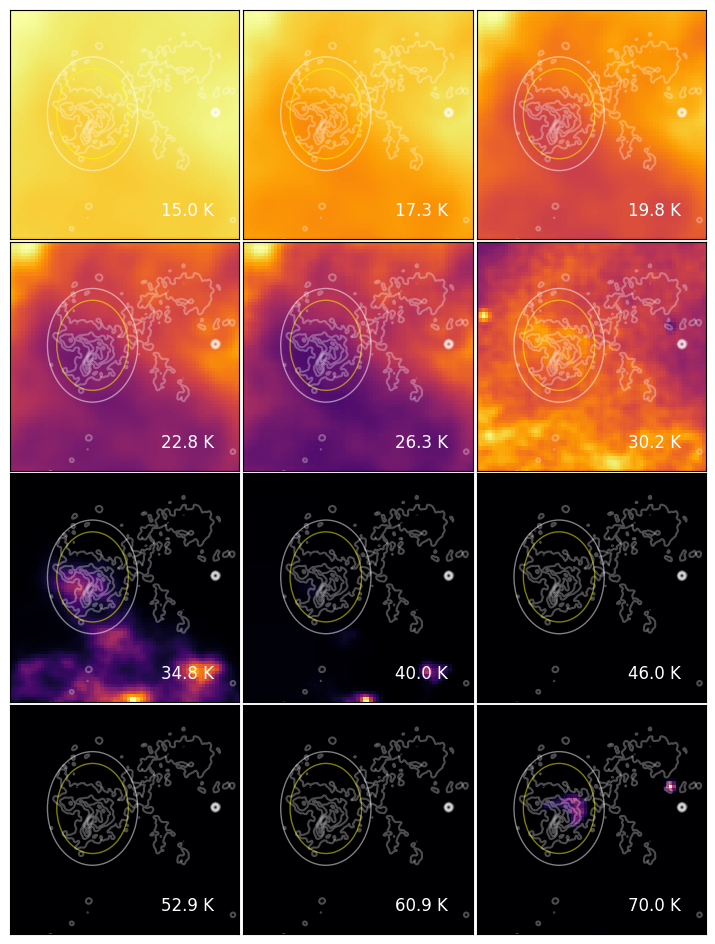

   Temperature  Dust Mass  SNR Dust Mass  Error
0         15.0     0.0041        -0.0000 0.0000
1         17.3     0.0074        -0.0002 0.0000
2         19.8     0.0238        -0.0013 0.0002
3         22.8     0.1753        -0.0177 0.0026
4         26.3     1.8695        -0.2461 0.0371
5         30.2     0.8901         0.0464 0.0052
6         34.8     0.0000         0.0000 0.0000
7         40.0     0.0000         0.0000 0.0000
8         46.0     0.0000         0.0000 0.0000
9         52.9     0.0000         0.0000 0.0000
10        60.9     0.0000         0.0000 0.0000
11        70.0     0.0001         0.0001 0.0000
12    Net Mass     0.8903         0.0465 0.0052


In [14]:
def SNR_mass(aperture,annulus,data):
    # use photutils to define background and source apertures
    # read in the SNR aperture and the annulus aperture via wcs
    # need to convert to pixel apertures to get the area factor out automatically
    # aperture - small aperture containing SNR
    # annulus = annulus for background subtraction
    # using median sigma clip
    # need to convert from Sky to pixel apertures to get area
    pix_large_aperture = annulus.to_pixel(wcs)
    pix_SNR_aperture = aperture.to_pixel(wcs)

    # do SNR_photometry (sum the pixels) in SNR aperture
    phot_table = aperture_photometry(data, pix_SNR_aperture)
    SNR_aperture_mass = phot_table['aperture_sum']

    # want to get the STD of the SNR aperture pixels so need to do following
    SNR_masks = pix_SNR_aperture.to_mask(method='center')
    SNR_data = SNR_masks[0].multiply(data)
    SNR_mask=SNR_masks[0].data
    SNR_data_1d=SNR_data[SNR_mask>0] #Standard DEVIATION OF THIS
    SNR_data_1d.shape # this is the pixel values in the annulus only

    # background annulus statistics - need to mask out annulus area to get the pixel values
    # this is to get background level (using median sigma clipping)
    annulus_masks = pix_large_aperture.to_mask(method='center')
    annulus_data =  annulus_masks[0].multiply(data)
    mask=annulus_masks[0].data
    annulus_data_1d=annulus_data[mask>0]
    annulus_data_1d.shape # this is the pixel values in the annulus only
    noise_level = 5 # sigma level for clipping data
    # need to ignore pixels with zeros since this affects stats
    mean_sigclip, median_sigclip, sigma_sigclip = \
    stats.sigma_clipped_stats(annulus_data_1d,sigma=noise_level,cenfunc=np.median) # median sig clip of pixels in annulus_data

    #pix_SNR_aperture_area = np.pi * ((innerR)**2)
    backg_level = mean_sigclip * pix_SNR_aperture.area #median value of background in SNR aperture
    Final_SNR_mass = SNR_aperture_mass - backg_level #mass in SNR aperture minus background

    sigma_cal=0.07*Final_SNR_mass
    sigma_snr= np.std(SNR_data_1d)*np.sqrt(pix_SNR_aperture.area)
    sigma_bkg = sigma_sigclip * (1./np.sqrt(pix_large_aperture.area)) * pix_SNR_aperture.area
    sigma_2_total=np.sqrt((sigma_cal**2)+(sigma_snr**2)+(sigma_bkg**2))

    # error in masses: variance of median = pi/2 x variance of mean = std^2/N where N=no pixels in annulus for median calculation
    return phot_table['aperture_sum'],Final_SNR_mass,sigma_2_total

#setting up the loop that will be run for each beta,
# or once if beta is fixed

for i in range(len(betas)):
    sample=bigdata[i]
    hdr  = fits.getheader(headpath)
    wcs = WCS(fits.getheader(headpath)).sub(axes=2)

    figure = plt.figure(figsize=(9,12))
    grid = gridspec.GridSpec(4,3)
    grid.update(wspace=0.01, hspace=0.01)

    ax = []
    lat = []
    lon = []

    #the loop that runs through each temperature map
    for t in range(tempno):
        ax.append(plt.subplot(grid[t], projection=wcs))

        if (t<2):
            vmin = 0.
            vmax = 100
            scale_type = 'sinh'
        elif (t>=2) and (t<8):
            vmin = 0.5
            vmax = 100.
            scale_type = 'asinh'
        else:
            vmin= 0.001
            vmax= 100.
            scale_type = 'asinh'

        vmin = np.nanpercentile(sample[t,:,:], vmin)
        vmax = np.nanpercentile(sample[t,:,:], vmax)

        method    = [vis.SqrtStretch()  if scale_type == 'sqrt' else
                     vis.LogStretch()   if scale_type == 'log' else
                     vis.AsinhStretch() if scale_type == 'asinh' else
                     vis.SquaredStretch() if scale_type == 'squared' else
                     vis.SinhStretch() if scale_type == 'sinh' else
                     vis.LinearStretch()][0]

        norm      = vis.ImageNormalize(vmin=float(vmin), vmax=float(vmax), stretch=method)

        img = ax[t].imshow(np.nan_to_num(sample[t,:,:]), origin = 'lower',cmap='inferno')


        print('t in temp loop',t)
        ax[t].text(0.66,0.1,'{} K'.format(float_temp[t]), \
            transform=ax[t].transAxes, color='white',fontsize=12) #adding temperature caption
        # adding the SNR aperture
        SNR_circle = Circle((g350_ap,g350_dec), (g350_dust_size),edgecolor='yellow', facecolor='none',\
                             linewidth=1.0, alpha=0.5,transform=ax[t].get_transform('fk5'))
        ax[t].add_patch(SNR_circle)

        SNR_annulus = Circle((g350_ap,g350_dec), (g350_dust_size + 0.004),edgecolor='white', facecolor='none',\
                             linewidth=1.0, alpha=0.5,transform=ax[t].get_transform('fk5'))
        ax[t].add_patch(SNR_annulus)


        ax[t].contour(xray_hdu.data, transform=ax[t].get_transform(WCS(xray_hdu.header)), \
                 levels=[1e-08,6.97613e-08,1.40668e-07,2.35945e-07,3.73361e-07,5.78544e-07,8.89762e-07,1.36506e-06],colors='white', alpha=0.3)

        #plot formatting
        lon.append(ax[t].coords[0])
        lat.append(ax[t].coords[1])
        ax[t].set_xlim((25, 95))
        ax[t].set_ylim((25, 95))
        #hiding axes labels
        lon[t].set_ticklabel_visible(False)
        lat[t].set_ticklabel_visible(False)
        lon[t].set_ticks_visible(False)
        lat[t].set_ticks_visible(False)

        # get photometry done
        smallaperture_mass[i,t], G350_mass[i,t],error[i,t] = SNR_mass(smallaperture,annulusaperture,sample[t,:,:])


    float_temp = np.array(float_temp)
    #
    data = {
    'Temperature': float_temp.tolist(),
    'Dust Mass': (convert(smallaperture_mass[i]).tolist()),
    'SNR Dust Mass': (convert(G350_mass[i]).tolist()),
    'Error': (convert(error[i]).tolist())}


    MASSES_before_bkgsub[i]=convert(np.sum(smallaperture_mass[i,:][G350_mass[i,:] > 0]))
    MASSES[i]=convert(np.sum(G350_mass[i,:][G350_mass[i,:] > 0])) # net dust mass in aperture
    ERROR[i]=convert(np.sum((error[i,:][G350_mass[i,:] > 0])))

    data['Temperature'].append('Net Mass')
    data['Dust Mass'].append((MASSES_before_bkgsub[i]))
    data['SNR Dust Mass'].append((MASSES[i]))
    data['Error'].append((ERROR[i]))


    plt.show()
    figure.savefig('G350.1-0.3'+'.png',bbox_inches='tight')
    # Create a DataFrame from the data
    pd.options.display.float_format = '{:.4f}'.format
    df = pd.DataFrame(data)

# Display the DataFrame
    print(df)
    df.to_csv('output_table.tsv', sep='\t', index=False)



In [15]:
text = df.to_string(index=False)

# Save the text to a text file
with open('output_table.txt', 'w') as f:
    f.write(text)

df.to_csv('output_table.csv', sep=',', index=False)


ppmap high temp resolution
high spacial resolution
masses in temp bins

axhspan 12 to 25 , error bar

In [16]:
dust_mass=[0.004055,0.007421,0.023823,0.175254,1.869466,0.890136,0.0,0.0,0.0,0.0,0.0,0.000139]
SNR_dust_mass=[-0.000041,-0.000164,-0.001075,-0.013643,-0.193009,0.044066,0.0,0.0,0.0,0.0,0.000139]



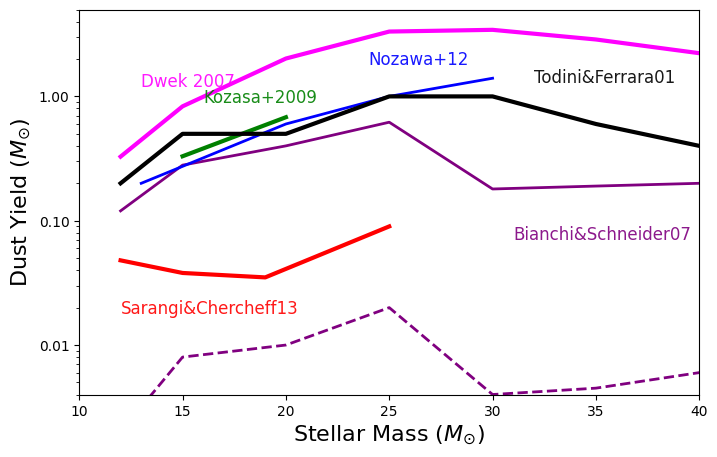

In [17]:
"""
------------MASSIVE STAR SUPERNOVA PLOT---------------------
"""
# progenitor mass
mstar_sne =[12,15,20,25,30,35,40]

# metals from Woosley and Weaver
metals_ww =[0.44,1.1,2.6,4.2,4.3,3.6,2.8]
carbon_ww = [0.081,0.16,0.21,0.12,0.027,0.033,0.045]
oxygen_ww =[]

#supernova dust masses from TF01, Bianchi
dust_bianchi_upp = [0.03,0.07,0.075,0.105,0.03,0.035,0.045]
dust_bianchi_low = [0.002,0.008,0.01,0.02,0.004,0.0045,0.006]
dust_tod = [0.2,0.5,0.5,1.0,1.0,0.6,0.4]

#set up dwek supernova metals (condensation efficiencies)
delta_ii_c = 0.5
delta_ii_o = 0.8

dust_dwek_sne =[]
for i in range(0,len(mstar_sne)):
    oxygen_ww.append(metals_ww[i] - carbon_ww[i])
    dust_dwek_sne.append((carbon_ww[i]*delta_ii_c)+(delta_ii_o*oxygen_ww[i]))

dust_cherch_sne =[0.048,0.038,0.035,0.09]
mstar_cherch_sne = [12,15,19,25]

dust_kos_sne =[0.33,0.68]
mstar_kos_sne = [15,20]

mdust_bian_sne =[0.12,0.28,0.4,0.62,0.18,0.19,0.2]
mstar_bian_sne=[12,15,20,25,30,35,40]

mdust_noz_sne =[0.2,0.6,1.0,1.4]
mstar_noz_sne =[13,20,25,30]

#plot figure
p.figure(figsize=(8,5))
ax=pylab.axes()
p.ylim(0.004,5)
p.xlim(10,40)
p.xlabel("Stellar Mass ($M_{\odot}$)",fontsize=16)
p.ylabel("Dust Yield ($M_{\odot}$)",fontsize=16)
p.semilogy(mstar_sne,dust_dwek_sne,linestyle='solid',color='magenta',linewidth=3,label='Dwek98/Calura08')
p.text(13,1.2,'Dwek 2007',fontsize=12,color='magenta',alpha=0.9)
p.semilogy(mstar_cherch_sne,dust_cherch_sne,linestyle='solid',color='red',linewidth=3,label='Cherchneff')
p.text(12,0.018,'Sarangi&Chercheff13',fontsize=12,color='red',alpha=0.9)
p.semilogy(mstar_kos_sne,dust_kos_sne,linestyle='solid',color='green',linewidth=3,label='Koz')
p.text(16,0.9,'Kozasa+2009',fontsize=12,color='green',alpha=0.9)
p.semilogy(mstar_bian_sne,mdust_bian_sne,linestyle='solid',color='purple',linewidth=2,label='Bianchi07')
p.text(31,0.07,'Bianchi&Schneider07',fontsize=12,color='purple',alpha=0.9)
p.semilogy(mstar_noz_sne,mdust_noz_sne,linestyle='solid',color='blue',linewidth=2)
p.text(24,1.8,'Nozawa+12',fontsize=12,color='blue',alpha=0.9)
p.plot(mstar_sne,dust_tod,linestyle='-',color='black',linewidth=3,label='TF01')
p.text(32,1.3,'Todini&Ferrara01',fontsize=12,color='black',alpha=0.9)
p.semilogy(mstar_sne,dust_bianchi_low,linestyle='dashed',color='purple',linewidth=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
p.show()
#p.savefig('dustyield_sne_cherch.pdf')
#p.legend(frameon=False,prop={'size':12})

cdense file
mass map

In [18]:
header = fits.getheader(headpath)
wcs = WCS(header)
pixel_size_x = header['CDELT1']
pixel_size_y = header['CDELT2']
print(pixel_size_x,"   ",pixel_size_y)

-0.001111     0.001111
